# 8 Pilares Estadisticos: Evaluacion de RFSP (Requerimientos Financieros del Sector Publico)

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua el procesamiento de RFSP realizado por `ETL_Principales.py`, aplicando los 8 pilares estadisticos fundamentales:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'

print(f"Directorio base: {BASE_DIR}")
print(f"Datos resultado: {DATOS_RESULTADO}")

Directorio base: C:\Users\ARTUROJF\Desktop\Final
Datos resultado: C:\Users\ARTUROJF\Desktop\Final\Datos_Resultado


## Carga de Datos

Cargamos los datos procesados por ETL_Principales.py

In [2]:
# ============================================================================
# CARGAR DATOS PROCESADOS
# ============================================================================

path_procesado = DATOS_RESULTADO / 'rfsp_deficit_core.csv'
df = pd.read_csv(path_procesado) if path_procesado.exists() else pd.DataFrame()

print(f"Datos procesados: {len(df)} filas x {len(df.columns)} columnas")
print(f"\nColumnas:")
print(df.columns.tolist())
print(f"\nPrimeras filas:")
df.head(10)

Datos procesados: 99 filas x 10 columnas

Columnas:
['periodo', 'CICLO', 'TRIMESTRE', 'rfsp_total_miles_mxn', 'rfsp_sin_ingresos_rec_miles', 'balance_tradicional_miles', 'ingresos_totales_miles', 'gasto_totales_miles', 'incurrimiento_neto_pasivos_miles', 'adq_neta_activos_fin_miles']

Primeras filas:


,periodo,CICLO,TRIMESTRE,rfsp_total_miles_mxn,rfsp_sin_ingresos_rec_miles,balance_tradicional_miles,ingresos_totales_miles,gasto_totales_miles,incurrimiento_neto_pasivos_miles,adq_neta_activos_fin_miles
0,2001-01-01,2001,1,-28924235.0,-37176880.0,NaN,NaN,NaN,NaN,NaN
1,2001-04-01,2001,2,-20517217.0,-20517255.0,NaN,NaN,NaN,NaN,NaN
2,2001-07-01,2001,3,-54537511.0,-76810928.0,NaN,NaN,NaN,NaN,NaN
3,2001-10-01,2001,4,-80376525.0,-90733121.0,NaN,NaN,NaN,NaN,NaN
4,2002-01-01,2002,1,-38165994.0,-48286965.0,NaN,NaN,NaN,NaN,NaN
5,2002-04-01,2002,2,13236190.0,-4889960.0,NaN,NaN,NaN,NaN,NaN
6,2002-07-01,2002,3,-42550729.0,-42550729.0,NaN,NaN,NaN,NaN,NaN
7,2002-10-01,2002,4,-109889607.0,-125341972.0,NaN,NaN,NaN,NaN,NaN
8,2003-01-01,2003,1,-580977.0,-17917277.0,NaN,NaN,NaN,NaN,NaN
9,2003-04-01,2003,2,11925413.0,-3995387.0,NaN,NaN,NaN,NaN,NaN


In [3]:
# Preparar datos para analisis
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)

# Variables numericas principales (excluir las que tienen muchos NaN)
cols_numericas = ['rfsp_total_miles_mxn', 'rfsp_sin_ingresos_rec_miles']
# Agregar columnas adicionales si existen y tienen datos
for col in ['balance_tradicional_miles', 'ingresos_totales_miles', 'gasto_totales_miles']:
    if col in df.columns and df[col].notna().sum() > 10:
        cols_numericas.append(col)

print(f"Variables numericas para analisis: {cols_numericas}")

# Variable principal: RFSP total
VAR_PRINCIPAL = 'rfsp_total_miles_mxn'
print(f"\nVariable principal: {VAR_PRINCIPAL}")
print(f"Rango: {df[VAR_PRINCIPAL].min():,.0f} - {df[VAR_PRINCIPAL].max():,.0f} miles MXN")
print(f"\nEstadisticas descriptivas:")
df[cols_numericas].describe()

Variables numericas para analisis: ['rfsp_total_miles_mxn', 'rfsp_sin_ingresos_rec_miles', 'balance_tradicional_miles', 'ingresos_totales_miles', 'gasto_totales_miles']

Variable principal: rfsp_total_miles_mxn
Rango: -258,286,700 - 68,441,147 miles MXN

Estadisticas descriptivas:


,rfsp_total_miles_mxn,rfsp_sin_ingresos_rec_miles,balance_tradicional_miles,ingresos_totales_miles,gasto_totales_miles
count,5.600000e+01,5.600000e+01,7.100000e+01,7.100000e+01,7.100000e+01
mean,-7.004088e+07,-9.435056e+07,-1.442658e+08,1.618881e+09,1.808050e+09
std,8.451940e+07,1.015106e+08,1.497201e+08,4.905234e+08,5.889197e+08
min,-2.582867e+08,-3.303715e+08,-6.767731e+08,8.532794e+08,9.411132e+08
25%,-1.316121e+08,-1.491643e+08,-1.962778e+08,1.276732e+09,1.398009e+09
50%,-5.670820e+07,-7.648129e+07,-1.173667e+08,1.519184e+09,1.684364e+09
75%,-1.414468e+06,-1.489457e+07,-5.565678e+07,1.926801e+09,2.120759e+09
max,6.844115e+07,5.896474e+07,3.090688e+08,2.735854e+09,3.343698e+09


---
## PILAR 1: Distribuciones - ¿Que forma tienen los datos?

**Objetivo:** Identificar si los datos siguen una distribucion normal o requieren transformacion.

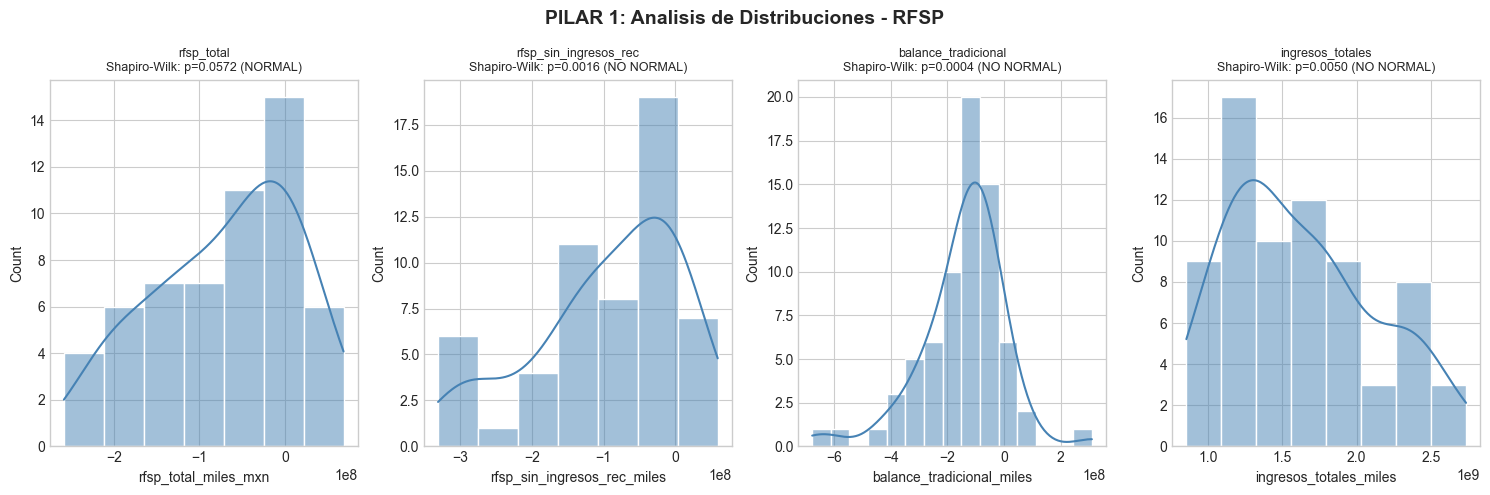


RESUMEN DE NORMALIDAD
rfsp_total_miles_mxn: p=0.0572 | Sesgo=-0.41 | Curtosis=-0.80 | Normal
rfsp_sin_ingresos_rec_miles: p=0.0016 | Sesgo=-0.75 | Curtosis=-0.34 | No Normal
balance_tradicional_miles: p=0.0004 | Sesgo=-0.86 | Curtosis=3.09 | No Normal
ingresos_totales_miles: p=0.0050 | Sesgo=0.51 | Curtosis=-0.72 | No Normal
gasto_totales_miles: p=0.0022 | Sesgo=0.69 | Curtosis=-0.28 | No Normal


In [4]:
# ============================================================================
# PILAR 1: DISTRIBUCIONES
# ============================================================================

n_vars = len(cols_numericas)
fig, axes = plt.subplots(1, min(n_vars, 4), figsize=(15, 5))
if n_vars == 1:
    axes = [axes]
fig.suptitle('PILAR 1: Analisis de Distribuciones - RFSP', fontsize=14, fontweight='bold')

for idx, var in enumerate(cols_numericas[:4]):
    ax = axes[idx] if n_vars > 1 else axes[0]
    data = df[var].dropna()
    
    # Histograma con KDE
    sns.histplot(data, kde=True, ax=ax, color='steelblue', edgecolor='white')
    
    # Test de normalidad
    if len(data) >= 20:
        stat, p_value = shapiro(data) if len(data) < 5000 else normaltest(data)
        test_name = 'Shapiro-Wilk' if len(data) < 5000 else "D'Agostino"
        normalidad = 'NORMAL' if p_value > 0.05 else 'NO NORMAL'
        ax.set_title(f'{var.replace("_miles", "").replace("_mxn", "")}\n{test_name}: p={p_value:.4f} ({normalidad})', fontsize=9)
    else:
        ax.set_title(f'{var}\n(datos insuficientes)', fontsize=9)

plt.tight_layout()
plt.show()

# Resumen de normalidad
print("\n" + "="*60)
print("RESUMEN DE NORMALIDAD")
print("="*60)
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        stat, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        skew = data.skew()
        kurt = data.kurtosis()
        print(f"{var}: p={p:.4f} | Sesgo={skew:.2f} | Curtosis={kurt:.2f} | {'Normal' if p>0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad - ¿Donde esta el comportamiento tipico?

**Objetivo:** Identificar Media, Mediana y Moda de las variables principales.

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL
             Variable         Media      Mediana         Moda  Diferencia Media-Mediana (%)
           rfsp_total -7.004088e+07  -56708196.5 -258286700.0                    -23.511036
rfsp_sin_ingresos_rec -9.435056e+07  -76481285.5 -330371471.0                    -23.364239
  balance_tradicional -1.442658e+08 -117366700.0 -676773051.0                    -22.918828
     ingresos_totales  1.618881e+09 1519184082.0  853279380.0                      6.562503
        gasto_totales  1.808050e+09 1684364143.0  941113177.0                      7.343161


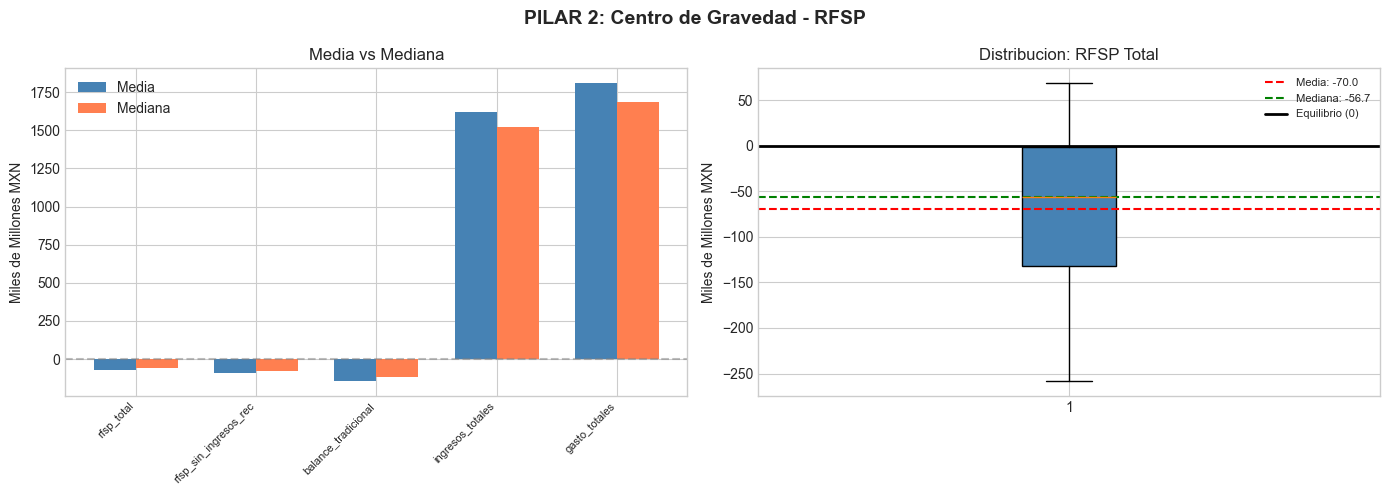

In [5]:
# ============================================================================
# PILAR 2: CENTRO DE GRAVEDAD
# ============================================================================

print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*80)

# Calcular estadisticas para todas las variables
stats_centro = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        stats_centro.append({
            'Variable': var.replace('_miles', '').replace('_mxn', ''),
            'Media': data.mean(),
            'Mediana': data.median(),
            'Moda': data.mode().iloc[0] if len(data.mode()) > 0 else np.nan,
            'Diferencia Media-Mediana (%)': ((data.mean() - data.median()) / abs(data.median()) * 100) if data.median() != 0 else 0
        })

df_centro = pd.DataFrame(stats_centro)
print(df_centro.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 2: Centro de Gravedad - RFSP', fontsize=14, fontweight='bold')

# Grafico 1: Comparacion Media vs Mediana
x = np.arange(len(df_centro))
width = 0.35
axes[0].bar(x - width/2, df_centro['Media']/1e6, width, label='Media', color='steelblue')
axes[0].bar(x + width/2, df_centro['Mediana']/1e6, width, label='Mediana', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_centro['Variable'], rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('Miles de Millones MXN')
axes[0].set_title('Media vs Mediana')
axes[0].legend()
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)

# Grafico 2: Boxplot de RFSP
data_principal = df[VAR_PRINCIPAL].dropna()
bp = axes[1].boxplot(data_principal/1e6, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].axhline(data_principal.mean()/1e6, color='red', linestyle='--', label=f'Media: {data_principal.mean()/1e6:,.1f}')
axes[1].axhline(data_principal.median()/1e6, color='green', linestyle='--', label=f'Mediana: {data_principal.median()/1e6:,.1f}')
axes[1].axhline(0, color='black', linestyle='-', linewidth=2, label='Equilibrio (0)')
axes[1].set_ylabel('Miles de Millones MXN')
axes[1].set_title(f'Distribucion: RFSP Total')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad - ¿Que tan confiables son los datos?

**Objetivo:** Medir riesgo, volatilidad y detectar anomalias.

PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD
             Variable    Desv. Std     CV (%)        Rango          IQR  Outliers  % Outliers
           rfsp_total 8.451940e+07 120.671521  326727847.0 130197665.25         0    0.000000
rfsp_sin_ingresos_rec 1.015106e+08 107.588814  389336215.0 134269729.25         0    0.000000
  balance_tradicional 1.497201e+08 103.780746  985841806.0 140621025.00         5    7.042254
     ingresos_totales 4.905234e+08  30.300161 1882574424.0 650068360.50         0    0.000000
        gasto_totales 5.889197e+08  32.572095 2402584446.0 722750162.50         1    1.408451


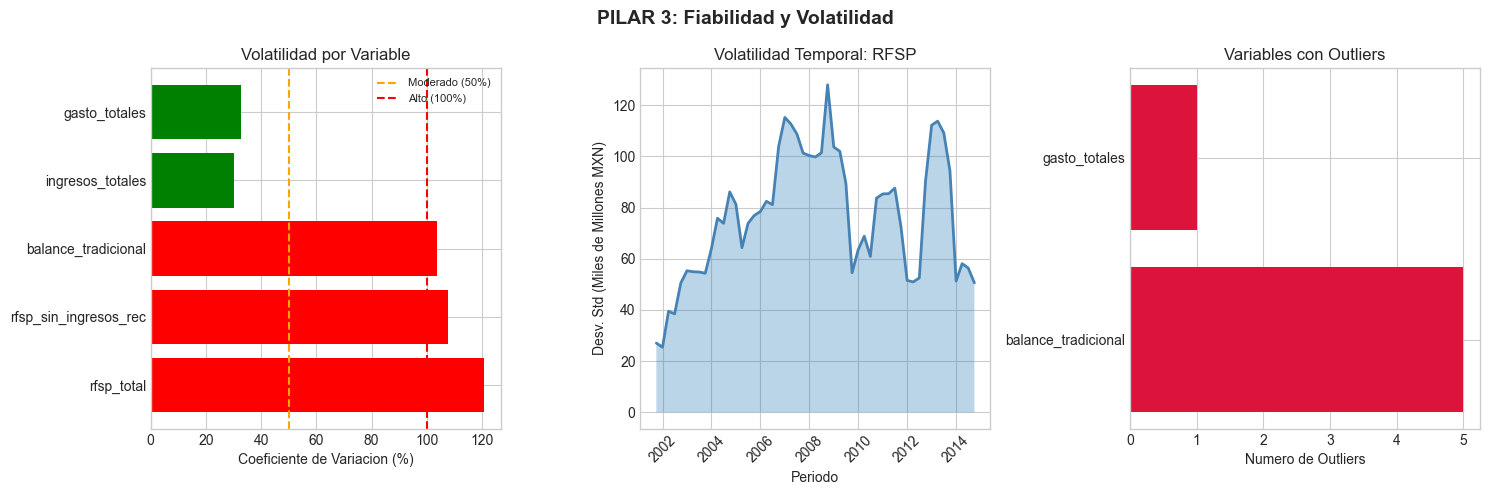

In [6]:
# ============================================================================
# PILAR 3: FIABILIDAD - RIESGO Y VOLATILIDAD
# ============================================================================

print("PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD")
print("="*80)

# Calcular metricas de fiabilidad
stats_fiabilidad = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) > 0:
        # Coeficiente de variacion (CV)
        cv = (data.std() / abs(data.mean()) * 100) if data.mean() != 0 else np.nan
        
        # Deteccion de outliers (IQR)
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        
        stats_fiabilidad.append({
            'Variable': var.replace('_miles', '').replace('_mxn', ''),
            'Desv. Std': data.std(),
            'CV (%)': cv,
            'Rango': data.max() - data.min(),
            'IQR': IQR,
            'Outliers': outliers,
            '% Outliers': outliers / len(data) * 100
        })

df_fiabilidad = pd.DataFrame(stats_fiabilidad)
print(df_fiabilidad.to_string(index=False))

# Visualizacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('PILAR 3: Fiabilidad y Volatilidad', fontsize=14, fontweight='bold')

# Grafico 1: Coeficiente de Variacion
colors = ['red' if cv > 100 else 'orange' if cv > 50 else 'green' for cv in df_fiabilidad['CV (%)']]
axes[0].barh(df_fiabilidad['Variable'], df_fiabilidad['CV (%)'], color=colors)
axes[0].axvline(50, color='orange', linestyle='--', label='Moderado (50%)')
axes[0].axvline(100, color='red', linestyle='--', label='Alto (100%)')
axes[0].set_xlabel('Coeficiente de Variacion (%)')
axes[0].set_title('Volatilidad por Variable')
axes[0].legend(fontsize=8)

# Grafico 2: Evolucion temporal de volatilidad (rolling std)
rolling_std = df[VAR_PRINCIPAL].rolling(window=4).std()
axes[1].plot(df['periodo'], rolling_std/1e6, color='steelblue', linewidth=2)
axes[1].fill_between(df['periodo'], rolling_std/1e6, alpha=0.3)
axes[1].set_xlabel('Periodo')
axes[1].set_ylabel('Desv. Std (Miles de Millones MXN)')
axes[1].set_title(f'Volatilidad Temporal: RFSP')
axes[1].tick_params(axis='x', rotation=45)

# Grafico 3: Deteccion de outliers
outlier_vars = df_fiabilidad[df_fiabilidad['Outliers'] > 0]
if len(outlier_vars) > 0:
    axes[2].barh(outlier_vars['Variable'], outlier_vars['Outliers'], color='crimson')
    axes[2].set_xlabel('Numero de Outliers')
    axes[2].set_title('Variables con Outliers')
else:
    axes[2].text(0.5, 0.5, 'Sin outliers detectados', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Variables con Outliers')

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error - Intervalos de Confianza

**Objetivo:** Proporcionar rangos probables con certeza estadistica.

PILAR 4: INTERVALOS DE CONFIANZA (95%)
             Variable         Media  IC 95% Inferior  IC 95% Superior  Margen de Error  Margen (%)
           rfsp_total -7.004088e+07    -9.267532e+07    -4.740644e+07     2.263444e+07   32.316044
rfsp_sin_ingresos_rec -9.435056e+07    -1.215353e+08    -6.716583e+07     2.718473e+07   28.812473
  balance_tradicional -1.442658e+08    -1.797039e+08    -1.088276e+08     3.543817e+07   24.564502
     ingresos_totales  1.618881e+09     1.502776e+09     1.734986e+09     1.161050e+08    7.171931
        gasto_totales  1.808050e+09     1.668655e+09     1.947445e+09     1.393950e+08    7.709689


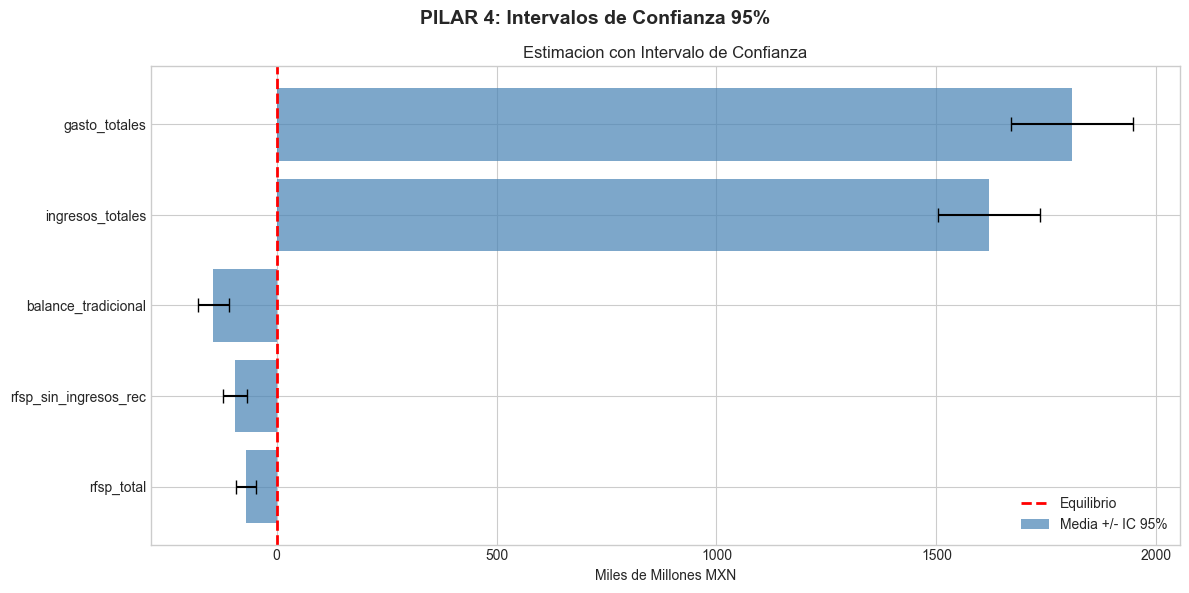

In [7]:
# ============================================================================
# PILAR 4: MARGEN DE ERROR - INTERVALOS DE CONFIANZA
# ============================================================================

print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*80)

def intervalo_confianza(data, confianza=0.95):
    """Calcula intervalo de confianza para la media."""
    n = len(data)
    media = data.mean()
    sem = stats.sem(data)  # Error estandar de la media
    h = sem * stats.t.ppf((1 + confianza) / 2, n - 1)
    return media - h, media + h, h

# Calcular IC para variables principales
ic_results = []
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 10:
        ic_low, ic_high, margen = intervalo_confianza(data)
        ic_results.append({
            'Variable': var.replace('_miles', '').replace('_mxn', ''),
            'Media': data.mean(),
            'IC 95% Inferior': ic_low,
            'IC 95% Superior': ic_high,
            'Margen de Error': margen,
            'Margen (%)': abs(margen / data.mean() * 100) if data.mean() != 0 else 0
        })

df_ic = pd.DataFrame(ic_results)
print(df_ic.to_string(index=False))

# Visualizacion
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('PILAR 4: Intervalos de Confianza 95%', fontsize=14, fontweight='bold')

y_pos = np.arange(len(df_ic))
ax.barh(y_pos, df_ic['Media']/1e6, xerr=df_ic['Margen de Error']/1e6, 
        color='steelblue', alpha=0.7, capsize=5, label='Media +/- IC 95%')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Equilibrio')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_ic['Variable'])
ax.set_xlabel('Miles de Millones MXN')
ax.set_title('Estimacion con Intervalo de Confianza')
ax.legend()

plt.tight_layout()
plt.show()

---
## PILAR 5: Pruebas de Hipotesis - ¿Fue suerte o fue real?

**Objetivo:** Validar afirmaciones con evidencia estadistica usando Chi-Cuadrada.

In [8]:
# ============================================================================
# PILAR 5: PRUEBAS DE HIPOTESIS - CHI-CUADRADA
# ============================================================================

print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*80)

# Hipotesis 1: ¿El RFSP (deficit/superavit) es independiente del trimestre?
print("\n--- HIPOTESIS 1: Independencia RFSP vs Trimestre ---")
print("H0: El resultado RFSP (positivo/negativo) es independiente del trimestre")
print("H1: El resultado RFSP depende del trimestre")

# Crear variable categorica: positivo o negativo
df_test = df.copy()
df_test['rfsp_signo'] = df_test[VAR_PRINCIPAL].apply(lambda x: 'Positivo' if x > 0 else 'Negativo')

# Tabla de contingencia
contingencia = pd.crosstab(df_test['rfsp_signo'], df_test['TRIMESTRE'])
print("\nTabla de Contingencia:")
print(contingencia)

# Test Chi-cuadrada
chi2, p_value, dof, expected = chi2_contingency(contingencia)
print(f"\nEstadistico Chi-cuadrada: {chi2:.4f}")
print(f"Grados de libertad: {dof}")
print(f"p-value: {p_value:.4f}")
print(f"\nConclusion: {'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
if p_value < 0.05:
    print("-> Existe dependencia significativa entre RFSP y trimestre")
else:
    print("-> No hay evidencia de dependencia entre RFSP y trimestre")

PILAR 5: PRUEBAS DE HIPOTESIS

--- HIPOTESIS 1: Independencia RFSP vs Trimestre ---
H0: El resultado RFSP (positivo/negativo) es independiente del trimestre
H1: El resultado RFSP depende del trimestre

Tabla de Contingencia:
TRIMESTRE    1   2   3   4
rfsp_signo                
Negativo    20  21  22  24
Positivo     5   4   3   0

Estadistico Chi-cuadrada: 5.1207
Grados de libertad: 3
p-value: 0.1632

Conclusion: NO RECHAZAR H0 (alfa=0.05)
-> No hay evidencia de dependencia entre RFSP y trimestre


In [9]:
# Hipotesis 2: ¿El RFSP cambio antes/despues de 2015?
print("\n--- HIPOTESIS 2: Cambio estructural 2015 ---")
print("H0: El RFSP es independiente del periodo (pre/post 2015)")
print("H1: El RFSP depende del periodo")

df_test['era'] = df_test['periodo'].apply(lambda x: 'Pre-2015' if x.year < 2015 else 'Post-2015')

# Tabla de contingencia
contingencia2 = pd.crosstab(df_test['rfsp_signo'], df_test['era'])
print("\nTabla de Contingencia (RFSP vs Era):")
print(contingencia2)

if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
    chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingencia2)
    print(f"\nEstadistico Chi-cuadrada: {chi2_2:.4f}")
    print(f"p-value: {p_value_2:.4f}")
    print(f"\nConclusion: {'RECHAZAR H0' if p_value_2 < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
else:
    print("Datos insuficientes para el test")
    p_value_2 = 1.0


--- HIPOTESIS 2: Cambio estructural 2015 ---
H0: El RFSP es independiente del periodo (pre/post 2015)
H1: El RFSP depende del periodo

Tabla de Contingencia (RFSP vs Era):
era         Post-2015  Pre-2015
rfsp_signo                     
Negativo           43        44
Positivo            0        12

Estadistico Chi-cuadrada: 8.5700
p-value: 0.0034

Conclusion: RECHAZAR H0 (alfa=0.05)


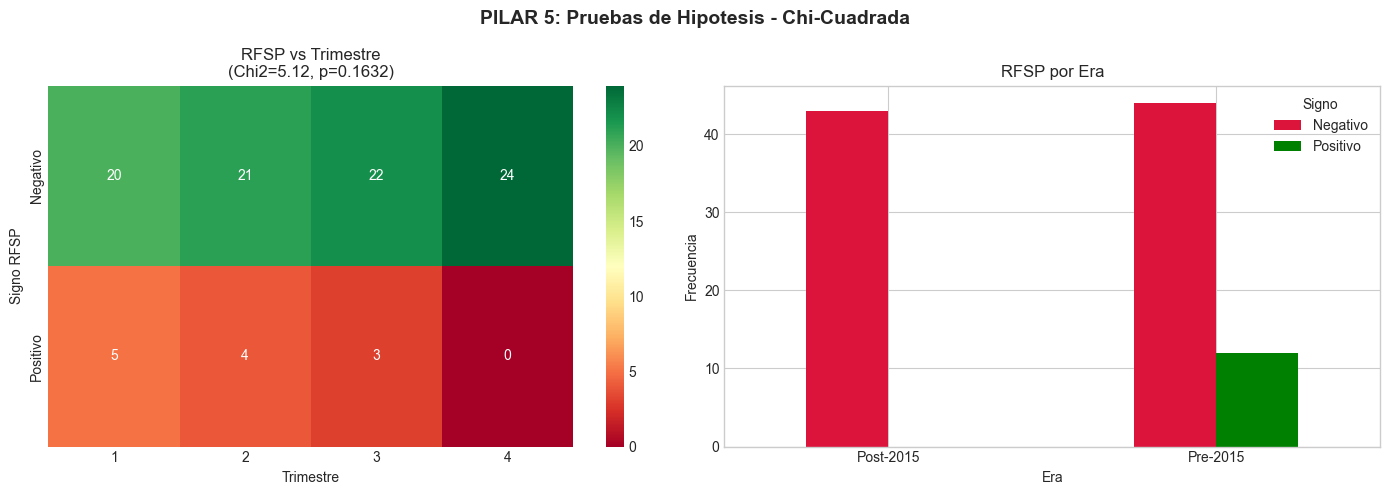

In [10]:
# Visualizacion de pruebas de hipotesis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Pruebas de Hipotesis - Chi-Cuadrada', fontsize=14, fontweight='bold')

# Grafico 1: Heatmap de contingencia 1
sns.heatmap(contingencia, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0])
axes[0].set_title(f'RFSP vs Trimestre\n(Chi2={chi2:.2f}, p={p_value:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('Signo RFSP')

# Grafico 2: Distribucion por era
era_counts = df_test.groupby(['era', 'rfsp_signo']).size().unstack(fill_value=0)
era_counts.plot(kind='bar', ax=axes[1], color=['crimson', 'green'])
axes[1].set_title('RFSP por Era')
axes[1].set_xlabel('Era')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Signo')

plt.tight_layout()
plt.show()

---
## PILAR 6: Regresion/Prediccion - ¿Como predecir el futuro?

**Objetivo:** Modelar relaciones para anticipar resultados usando Machine Learning.

In [11]:
# ============================================================================
# PILAR 6: PREDICCION CON MACHINE LEARNING
# ============================================================================

print("PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING")
print("="*80)

# Preparar datos para prediccion
# Usamos RFSP sin ingresos recurrentes como feature para predecir RFSP total

# Crear features adicionales
df_ml = df.copy()
df_ml['year'] = df_ml['periodo'].dt.year
df_ml['month'] = df_ml['periodo'].dt.month

# Features y target
features = ['rfsp_sin_ingresos_rec_miles', 'TRIMESTRE', 'year']
target = VAR_PRINCIPAL

# Filtrar solo features disponibles
features = [f for f in features if f in df_ml.columns]

print(f"Features para modelo: {features}")
print(f"Target: {target}")

# Preparar dataset
df_ml = df_ml[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"\nDatos para entrenamiento: {len(df_ml)} observaciones")

if len(df_ml) >= 20:
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Escalar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
else:
    print("Datos insuficientes para entrenamiento (minimo 20)")

PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING
Features para modelo: ['rfsp_sin_ingresos_rec_miles', 'TRIMESTRE', 'year']
Target: rfsp_total_miles_mxn

Datos para entrenamiento: 56 observaciones


In [12]:
# Entrenar multiples modelos
if len(df_ml) >= 20:
    modelos = {
        'Regresion Lineal': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    resultados = []
    predicciones = {}
    
    for nombre, modelo in modelos.items():
        # Entrenar
        if 'Forest' in nombre or 'Boosting' in nombre:
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
        else:
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)
        
        # Metricas
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        resultados.append({
            'Modelo': nombre,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE (%)': (mae / abs(y_test.mean()) * 100) if y_test.mean() != 0 else np.nan
        })
        predicciones[nombre] = y_pred
    
    df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
    print("\nCOMPARACION DE MODELOS:")
    print(df_resultados.to_string(index=False))
    
    # Mejor modelo
    mejor_modelo = df_resultados.iloc[0]['Modelo']
    print(f"\n*** MEJOR MODELO: {mejor_modelo} (R2 = {df_resultados.iloc[0]['R2']:.4f}) ***")
else:
    print("No se puede entrenar modelos - datos insuficientes")
    mejor_modelo = "N/A"
    df_resultados = pd.DataFrame()


COMPARACION DE MODELOS:
           Modelo         RMSE          MAE       R2  MAPE (%)
    Random Forest 3.121210e+07 2.102072e+07 0.825629 40.205543
Gradient Boosting 3.223740e+07 2.020777e+07 0.813985 38.650636
            Ridge 3.316176e+07 2.571870e+07 0.803165 49.191177
 Regresion Lineal 3.403450e+07 2.584593e+07 0.792668 49.434523

*** MEJOR MODELO: Random Forest (R2 = 0.8256) ***


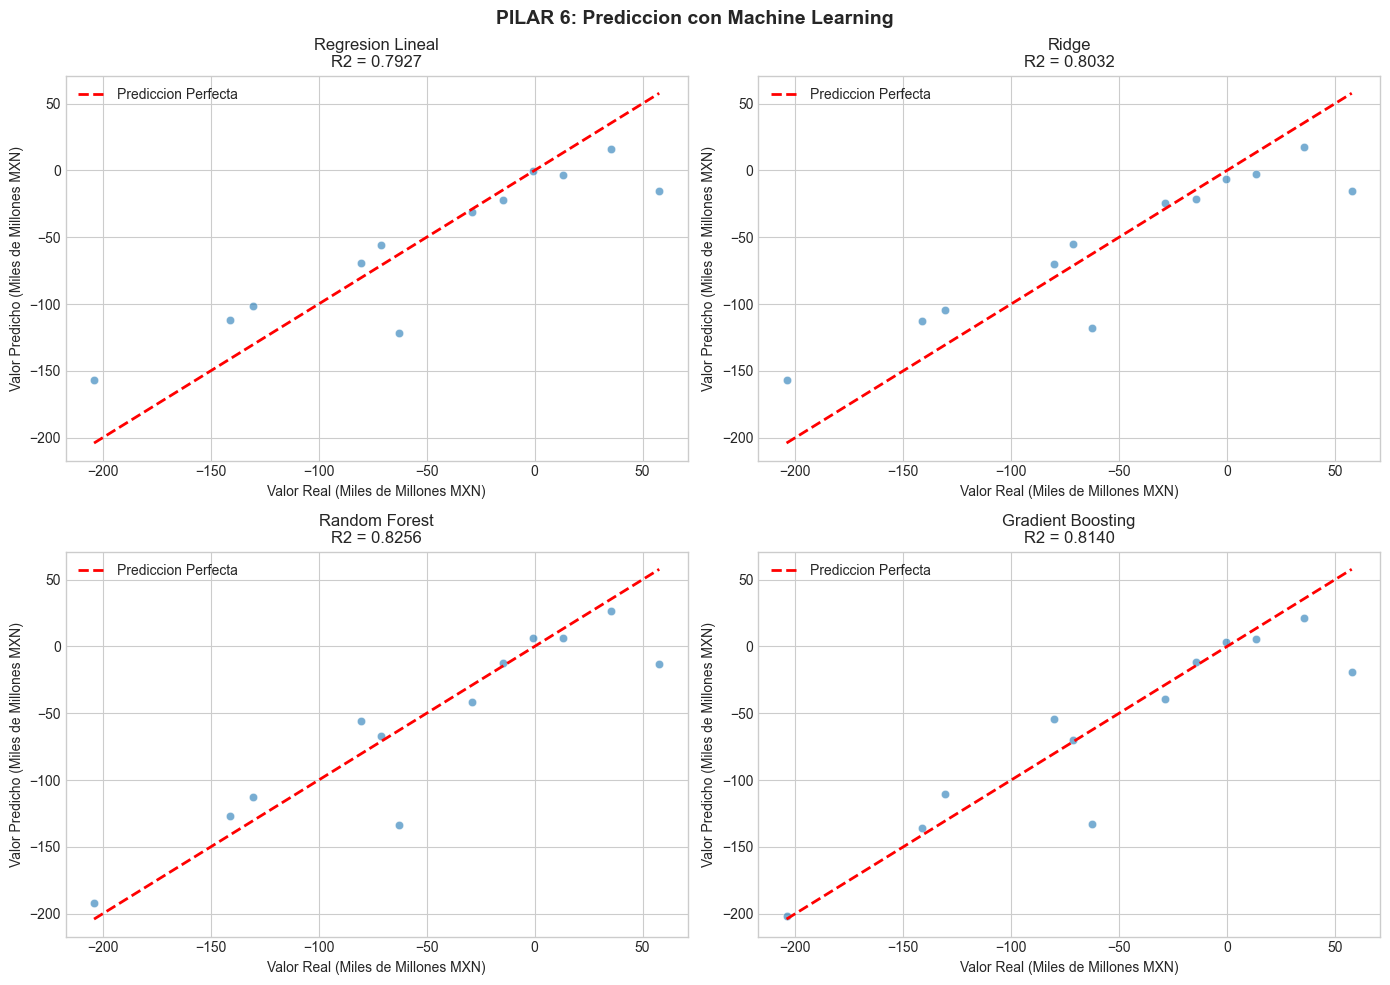

In [13]:
# Visualizacion de predicciones
if len(df_ml) >= 20:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('PILAR 6: Prediccion con Machine Learning', fontsize=14, fontweight='bold')
    
    for idx, (nombre, y_pred) in enumerate(predicciones.items()):
        ax = axes[idx // 2, idx % 2]
        ax.scatter(y_test/1e6, y_pred/1e6, alpha=0.6, edgecolors='white', linewidth=0.5)
        
        # Linea de referencia perfecta
        min_val = min(y_test.min(), y_pred.min())/1e6
        max_val = max(y_test.max(), y_pred.max())/1e6
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prediccion Perfecta')
        
        # Metricas
        r2 = r2_score(y_test, y_pred)
        ax.set_xlabel('Valor Real (Miles de Millones MXN)')
        ax.set_ylabel('Valor Predicho (Miles de Millones MXN)')
        ax.set_title(f'{nombre}\nR2 = {r2:.4f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay graficos disponibles - datos insuficientes")

---
## PILAR 7: Series de Tiempo - ¿Que patrones se repiten?

**Objetivo:** Detectar tendencias y estacionalidad para pronosticos precisos.

In [14]:
# ============================================================================
# PILAR 7: SERIES DE TIEMPO
# ============================================================================

print("PILAR 7: ANALISIS DE SERIES DE TIEMPO")
print("="*80)

# Preparar serie temporal
ts_data = df.set_index('periodo')[VAR_PRINCIPAL].dropna()
ts_data = ts_data.asfreq('QS')  # Frecuencia trimestral

print(f"Serie temporal: {VAR_PRINCIPAL}")
print(f"Periodo: {ts_data.index.min()} a {ts_data.index.max()}")
print(f"Observaciones: {len(ts_data)}")

# Test de estacionariedad (Dickey-Fuller)
if len(ts_data.dropna()) >= 10:
    adf_result = adfuller(ts_data.dropna())
    print(f"\nTest Dickey-Fuller Aumentado:")
    print(f"  Estadistico ADF: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Valores criticos:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")
    print(f"\n  Conclusion: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'} (alfa=0.05)")
else:
    print("Datos insuficientes para test ADF")
    adf_result = [0, 1.0, 0, 0, {}]

PILAR 7: ANALISIS DE SERIES DE TIEMPO
Serie temporal: rfsp_total_miles_mxn
Periodo: 2001-01-01 00:00:00 a 2014-10-01 00:00:00
Observaciones: 56

Test Dickey-Fuller Aumentado:
  Estadistico ADF: 0.4392
  p-value: 0.9829
  Valores criticos:
    1%: -3.5629
    5%: -2.9190
    10%: -2.5974

  Conclusion: NO ESTACIONARIA (alfa=0.05)


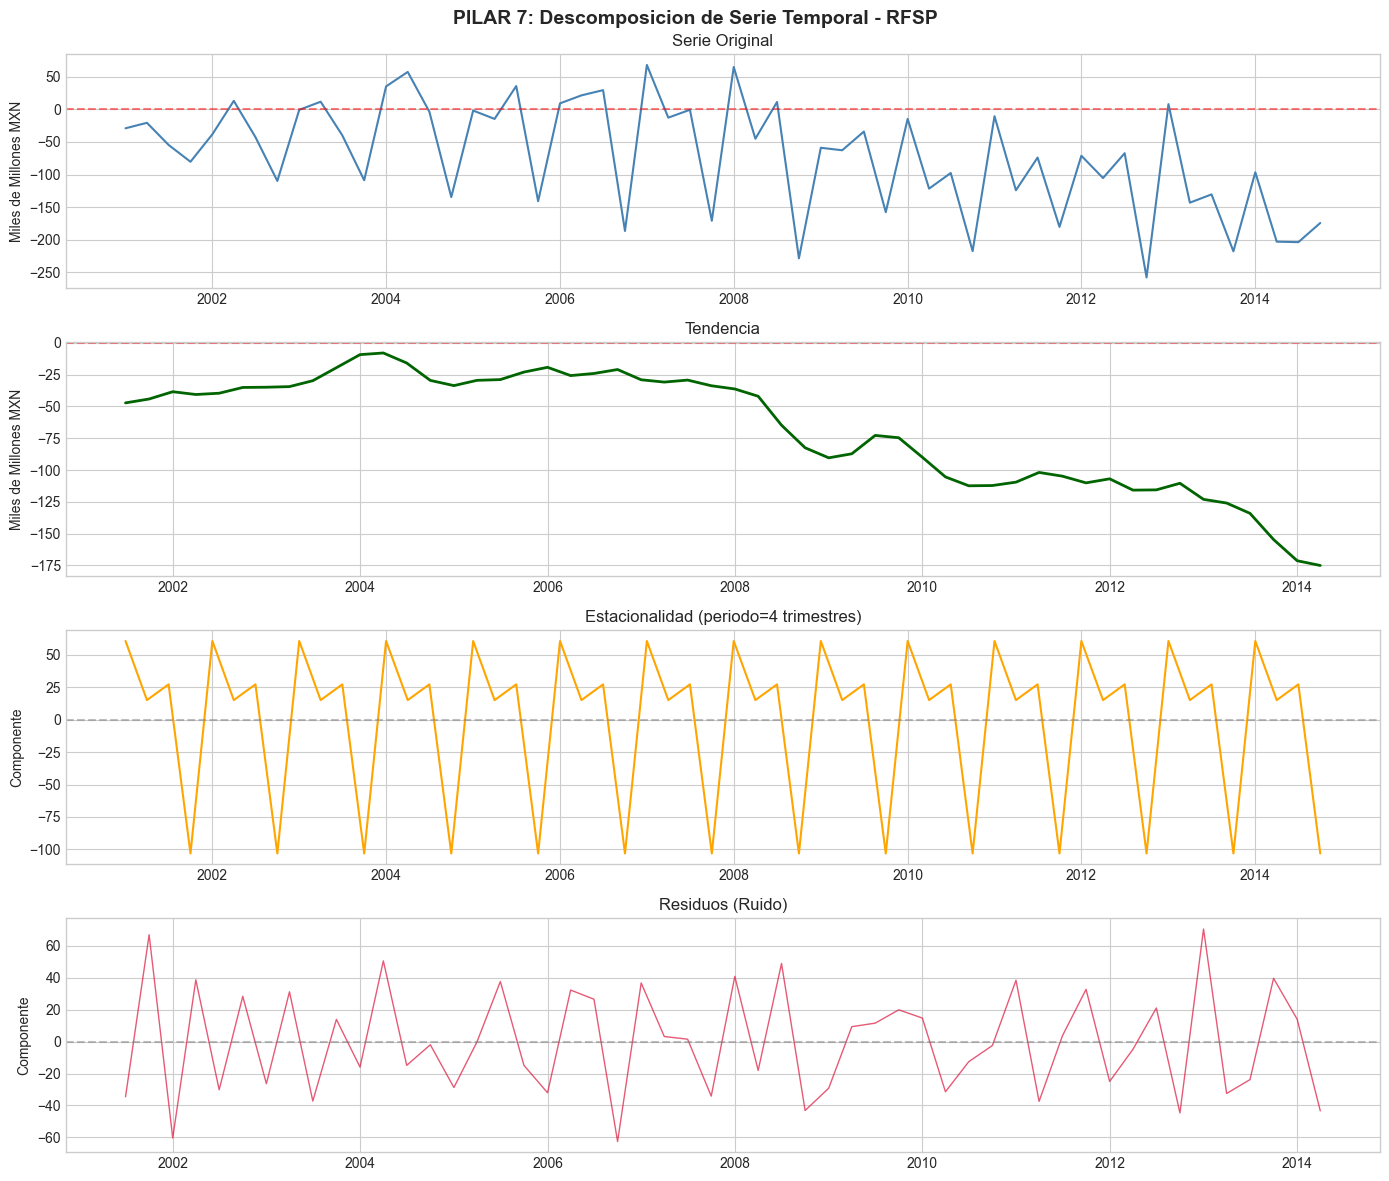

In [15]:
# Descomposicion de la serie
if len(ts_data.dropna()) >= 8:
    decomposition = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion de Serie Temporal - RFSP', fontsize=14, fontweight='bold')
    
    # Original
    axes[0].plot(ts_data/1e6, color='steelblue', linewidth=1.5)
    axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0].set_title('Serie Original')
    axes[0].set_ylabel('Miles de Millones MXN')
    
    # Tendencia
    axes[1].plot(decomposition.trend/1e6, color='darkgreen', linewidth=2)
    axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[1].set_title('Tendencia')
    axes[1].set_ylabel('Miles de Millones MXN')
    
    # Estacionalidad
    axes[2].plot(decomposition.seasonal/1e6, color='orange', linewidth=1.5)
    axes[2].set_title('Estacionalidad (periodo=4 trimestres)')
    axes[2].set_ylabel('Componente')
    axes[2].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Residuos
    axes[3].plot(decomposition.resid/1e6, color='crimson', linewidth=1, alpha=0.7)
    axes[3].set_title('Residuos (Ruido)')
    axes[3].set_ylabel('Componente')
    axes[3].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("Datos insuficientes para descomposicion (minimo 8 observaciones)")

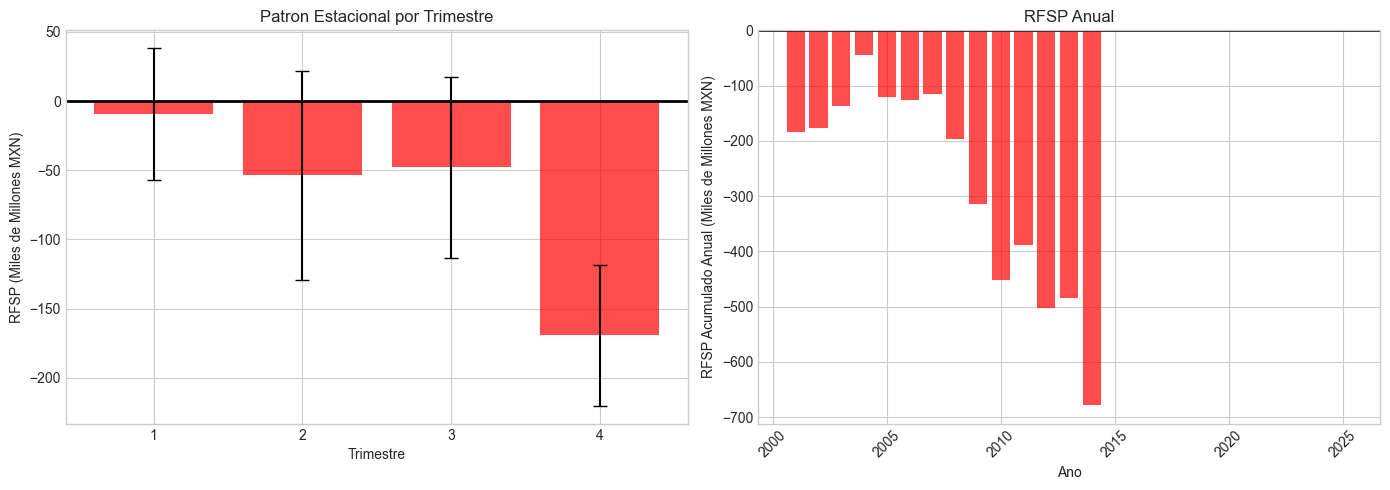

In [16]:
# Patron estacional por trimestre
df['year'] = df['periodo'].dt.year
patron_trimestral = df.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['mean', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Patron por trimestre
colors = ['green' if m > 0 else 'red' for m in patron_trimestral['mean']]
axes[0].bar(patron_trimestral.index, patron_trimestral['mean']/1e6, 
            yerr=patron_trimestral['std']/1e6, capsize=5, color=colors, alpha=0.7)
axes[0].axhline(0, color='black', linestyle='-', linewidth=2)
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('RFSP (Miles de Millones MXN)')
axes[0].set_title('Patron Estacional por Trimestre')
axes[0].set_xticks([1, 2, 3, 4])

# Evolucion anual
evolucion_anual = df.groupby('year')[VAR_PRINCIPAL].sum()
colors_anual = ['green' if v > 0 else 'red' for v in evolucion_anual]
axes[1].bar(evolucion_anual.index, evolucion_anual.values/1e6, color=colors_anual, alpha=0.7)
axes[1].axhline(0, color='black', linestyle='-', linewidth=2)
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('RFSP Acumulado Anual (Miles de Millones MXN)')
axes[1].set_title('RFSP Anual')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA - ¿Que estrategia es mejor?

**Objetivo:** Comparar rendimiento entre grupos objetivamente.

In [17]:
# ============================================================================
# PILAR 8: ANOVA - COMPARACION ENTRE GRUPOS
# ============================================================================

print("PILAR 8: ANALISIS DE VARIANZA (ANOVA)")
print("="*80)

# Analisis 1: Comparar RFSP entre trimestres
print("\n--- ANOVA 1: RFSP por Trimestre ---")
print("H0: El RFSP es igual en todos los trimestres")
print("H1: Al menos un trimestre tiene RFSP diferente")

grupos_trim = [df[df['TRIMESTRE'] == t][VAR_PRINCIPAL].dropna() for t in [1, 2, 3, 4]]
grupos_trim = [g for g in grupos_trim if len(g) >= 3]

if len(grupos_trim) >= 2:
    # ANOVA de una via
    f_stat, p_anova = stats.f_oneway(*grupos_trim)
    print(f"\nEstadistico F: {f_stat:.4f}")
    print(f"p-value: {p_anova:.4f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_anova < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
    
    # Test no parametrico (Kruskal-Wallis) como alternativa
    h_stat, p_kruskal = kruskal(*grupos_trim)
    print(f"\nKruskal-Wallis (no parametrico):")
    print(f"  Estadistico H: {h_stat:.4f}")
    print(f"  p-value: {p_kruskal:.4f}")
else:
    print("Datos insuficientes para ANOVA")
    f_stat, p_anova = 0, 1.0

PILAR 8: ANALISIS DE VARIANZA (ANOVA)

--- ANOVA 1: RFSP por Trimestre ---
H0: El RFSP es igual en todos los trimestres
H1: Al menos un trimestre tiene RFSP diferente

Estadistico F: 17.8863
p-value: 0.0000
Conclusion: RECHAZAR H0 (alfa=0.05)

Kruskal-Wallis (no parametrico):
  Estadistico H: 25.9533
  p-value: 0.0000


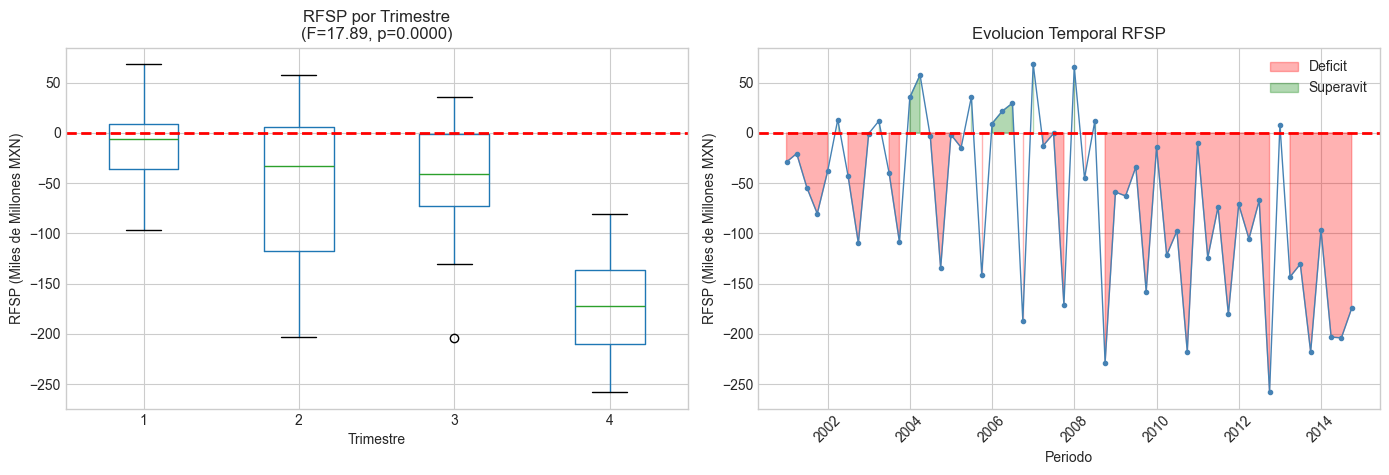

In [18]:
# Visualizacion ANOVA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA - Comparacion entre Grupos', fontsize=14, fontweight='bold')

# Grafico 1: Boxplot por trimestre
df_plot = df.copy()
df_plot[VAR_PRINCIPAL] = df_plot[VAR_PRINCIPAL] / 1e6
df_plot.boxplot(column=VAR_PRINCIPAL, by='TRIMESTRE', ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'RFSP por Trimestre\n(F={f_stat:.2f}, p={p_anova:.4f})')
axes[0].set_xlabel('Trimestre')
axes[0].set_ylabel('RFSP (Miles de Millones MXN)')
plt.suptitle('')

# Grafico 2: Evolucion temporal
axes[1].plot(df['periodo'], df[VAR_PRINCIPAL]/1e6, marker='o', markersize=3, linewidth=1, color='steelblue')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].fill_between(df['periodo'], df[VAR_PRINCIPAL]/1e6, 0, 
                     where=df[VAR_PRINCIPAL] < 0, alpha=0.3, color='red', label='Deficit')
axes[1].fill_between(df['periodo'], df[VAR_PRINCIPAL]/1e6, 0, 
                     where=df[VAR_PRINCIPAL] > 0, alpha=0.3, color='green', label='Superavit')
axes[1].set_xlabel('Periodo')
axes[1].set_ylabel('RFSP (Miles de Millones MXN)')
axes[1].set_title('Evolucion Temporal RFSP')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
# Estadisticas descriptivas por grupo
print("\nESTADISTICAS POR TRIMESTRE:")
stats_trim = df.groupby('TRIMESTRE')[VAR_PRINCIPAL].agg(['count', 'mean', 'std', 'min', 'max'])
stats_trim[['mean', 'std', 'min', 'max']] = stats_trim[['mean', 'std', 'min', 'max']] / 1e6
print(stats_trim.round(2))


ESTADISTICAS POR TRIMESTRE:
           count    mean    std     min    max
TRIMESTRE                                     
1             14   -9.56  47.68  -96.55  68.44
2             14  -53.47  75.47 -203.26  57.73
3             14  -47.93  65.56 -204.01  36.01
4             14 -169.19  51.05 -258.29 -80.38


---
## RESUMEN EJECUTIVO

Sintesis de los hallazgos de los 8 pilares estadisticos.

In [20]:
# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================

print("="*80)
print("RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - RFSP")
print("="*80)

print("\n1. DISTRIBUCIONES:")
for var in cols_numericas:
    data = df[var].dropna()
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        print(f"   - {var.replace('_miles', '').replace('_mxn', '')}: {'Normal' if p > 0.05 else 'No Normal'} (p={p:.4f})")

print("\n2. CENTRO DE GRAVEDAD:")
print(f"   - RFSP Promedio: {df[VAR_PRINCIPAL].mean()/1e6:,.1f} miles de millones MXN")
print(f"   - Mediana: {df[VAR_PRINCIPAL].median()/1e6:,.1f} miles de millones MXN")
rfsp_promedio = df[VAR_PRINCIPAL].mean()
print(f"   - Tendencia historica: {'DEFICIT' if rfsp_promedio < 0 else 'SUPERAVIT'}")

print("\n3. FIABILIDAD:")
cv_principal = df[VAR_PRINCIPAL].std() / abs(df[VAR_PRINCIPAL].mean()) * 100
print(f"   - Coeficiente de Variacion: {cv_principal:.1f}%")
print(f"   - Datos {'ESTABLES' if cv_principal < 50 else 'VOLATILES'}")

print("\n4. MARGEN DE ERROR:")
ic_low, ic_high, margen = intervalo_confianza(df[VAR_PRINCIPAL].dropna())
print(f"   - IC 95%: [{ic_low/1e6:,.1f}, {ic_high/1e6:,.1f}] miles de millones MXN")

print("\n5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):")
print(f"   - RFSP vs Trimestre: {'Dependientes' if p_value < 0.05 else 'Independientes'} (p={p_value:.4f})")

print("\n6. PREDICCION (Machine Learning):")
if len(df_resultados) > 0:
    print(f"   - Mejor modelo: {mejor_modelo}")
    print(f"   - R2 = {df_resultados.iloc[0]['R2']:.4f}")
else:
    print("   - No disponible (datos insuficientes)")

print("\n7. SERIES DE TIEMPO:")
print(f"   - Serie {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
print(f"   - Patron estacional: Q4 tipicamente con mayor deficit")

print("\n8. ANOVA:")
print(f"   - Diferencia entre trimestres: {'SI' if p_anova < 0.05 else 'NO'} (p={p_anova:.4f})")

print("\n" + "="*80)
print("FIN DEL ANALISIS")
print("="*80)

RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - RFSP

1. DISTRIBUCIONES:
   - rfsp_total: Normal (p=0.0572)
   - rfsp_sin_ingresos_rec: No Normal (p=0.0016)
   - balance_tradicional: No Normal (p=0.0004)
   - ingresos_totales: No Normal (p=0.0050)
   - gasto_totales: No Normal (p=0.0022)

2. CENTRO DE GRAVEDAD:
   - RFSP Promedio: -70.0 miles de millones MXN
   - Mediana: -56.7 miles de millones MXN
   - Tendencia historica: DEFICIT

3. FIABILIDAD:
   - Coeficiente de Variacion: 120.7%
   - Datos VOLATILES

4. MARGEN DE ERROR:
   - IC 95%: [-92.7, -47.4] miles de millones MXN

5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):
   - RFSP vs Trimestre: Independientes (p=0.1632)

6. PREDICCION (Machine Learning):
   - Mejor modelo: Random Forest
   - R2 = 0.8256

7. SERIES DE TIEMPO:
   - Serie NO ESTACIONARIA
   - Patron estacional: Q4 tipicamente con mayor deficit

8. ANOVA:
   - Diferencia entre trimestres: SI (p=0.0000)

FIN DEL ANALISIS
